In [1]:
import numpy as np
import pandas as pd

## Abstract 

Latent Dirichlet Allocation (LDA) is a common method of topic modelling. It’s a technique that automatically discover the topics that documents contain. It’s a generative topic probabilistic first proposed by David M.Blei, Andrew Y.Ng, and Michae l. Jordan to find the latent variables(topics) in a text corpus (collection of Documents). 

Latent Dirichlet Allocation is a three level hierarchical Bayesian model for collections of discrete data and implemented by variantional EM algorithm. Variantional inference is a method that approximates probability densities through optimizations and it’s faster and easier to implement & scale than the traditional method such as MCMC. To LDA, a document is just a collection of topics where each topics has a particular probability of generating specific words. We implement variantional EM algorithm to calculate the optimal parameters of probabilistic topic distributions of documents and probabilistic words distributions over topics by using techniques such as posterior inference, Newton-Raphson method, gradient descent, Hessian matrix, etc. By getthing these optimal parameters, we can assign each documents to different topics by probabilities. 

In this report, we will first introduce and analyze the LDA model in a mathematical way. And then we will implement the core functions and present the pseudo-codes of the LDA model. We also find ways to optimize our algorithm and at last we will use the simulated data and real world data to test the accuracy of our model. 


## Backgrounds 

The research paper we are using is the paper Latent Dirichlet Allocation written by David M Blei, Andrew Y.Ng and Michael I.Jordan. LDA is a common method of topic modelling. A short example is if I have a document and I don't know it’s belonging to the food topic or the fruit topic. After implementing the LDA model I will know the percentage distribution of topics of that document. LDA is not only restricted to topic modelling in text, actually it can be work on any set that can be represented as binary vectors or non binary vectors. However, the most popular usage of LDA is still the topic modelling in text. In order to give a more clear picture on the content of the model, we will present a more specific example. 

Suppose we have the following set of the sentences (documents):

1.	There are elephants, tigers, lions, dogs in the city’s zoo. 
2.	Eat an apple everyday, doctors go away. 
3.	Hunters said that there are tigers, bears and other wild animals in the forest so it’s very dangerous to go inside the forest alone. 
4.	Susan loves to eat tomatoes, broccoli and apple. 
5.	Unlike tigers who like to eat meats, rabbits love to eat carrot. 

LDA is a method that can discover the topics underlying each documents by self-learning:
1 & 3: 100% topic A
2 % 4: 100 topic B
5: 75% topic A and 25% topic B. 

Topic A: 40% tigers, 20% elephants, …. 
Topic B: 30% apple, 20% broccoli,… 

We will introduce the mathematical inductions of LDA and how LDA performs the discovery in the next section. 

We need LDA because in the real world, the dataset can be very huge with a lot of documents and information. So we need the tools that can search, organize and understand that vast amount of information. LDA provides us a method to summarize that large collections of information and discover the hidden topics under each documents. This is the most known application of LDA in the real world: topic modellings. We can achieve some basic text minings by using the LDA such as novelty detection, classification, relevance judgments and similarity. The advantage of LDA is that it’s easy to implement, very clear logic and it’s a probabilistic model (soft-clustering) with interpretable topics. The limitations of the LDA is that the method assumes the number of topics in the dataset are specified by the user or based on a poisson distribution, but this is subjective and always did not actually highlight the true distribution of the topics. Second limitation is the relatively long running time than the other natural language processing alrogithms. The thrid limitation is that LDA did not consider the order of the words when it's learning. Sometimes the orders of the word may also affect the topic that document belonging to.  

## Mathematical Analysis 

### Parameter Declaration: 

K: number of topics 

M: number of documents

N: Number of words in the documents 

$\theta_m$: distribution for document m

$\alpha$: a K dimensional vector, the topic distribution of K topics. 

$\beta$: K x V matrix, $\beta_{ij}$ means the probability of $j^{th}$ word of $i^{th}$ topic. 

z: topics 

w: words 

D: Collection of Documents 

$\phi$: M x N x K matrix, means probability distribution of each topic of words in each documents. 

$\gamma$: M x K matrix, means the probability distribution of topics for each documents.

LDA assumes that the latent topics of a document comes from a multinomial distribution and the words also comes from a multinomial distribution conditional on the latent topics.

In this problem,we have a set of M documents, D, which are mixture of latent topics we have a dictionary of unique words,W, with size V. We donate N as the number of words in a document.

The generative process of LDA is described below.

- 1. choose N (the number of words in the document) from a poisson distribution with $\lambda=\xi$, $N\sim Poisson(\xi)$
    
- 2. choose $\theta\sim Dir(\alpha)$ 

- for each of N words $w_n$:
        
- (a) choose a topic $z_n \sim Multinomial(\theta)$

- (b) choose a word $w_n \sim Multinomial(\beta_{z_n})$, $\beta \in \mathbb{R}^{k \times V}$ and $\beta_{z_n}$ is the $z_n$ row of the $\beta$

The probability density of Dirichlet distribution is $p(\theta|\alpha)=\frac{\Gamma(\sum_{i=1}^k\alpha_i)}{\prod_{i=1}^k\Gamma(\alpha_i)}\theta_1^{\alpha_1-1}...\theta_k^{\alpha_k-1}$ where $\alpha \in \mathbb{R}^k$ ,$\theta \in \mathbb{R}^k$ and $\sum_{i=1}^k\theta_i=1$, $\alpha_i\gt0$

The Dirichlet distribution is an expansion of Gamma distribution into multivariable space and it is the conjugate distribution of multinomial distribution which can make our calculation much more easier.

From the assumption above, we can easily derive following equations.

$p(\theta,z,w|\alpha,\beta)=p(\theta|\alpha)\prod_{n=1}^Np(z_n|\theta)p(w_n|z_n,\beta)$


$p(\theta,w|\alpha,\beta) = p(\theta|\alpha)\prod_{n=1}^N(\sum_{z_n}p(z_n|\theta)p(w_n|z_n,\beta))$

The likelihood of a single document can be expressed as

$$p(w|\alpha,\beta)=\int p(\theta|\alpha)\prod_{n=1}^N(\sum_{z_n}p(z_n|\theta)p(w_n|z_n,\beta))d\theta$$

And the likelihood of Corpus is:

$$
p(D|\alpha,\beta)=\prod_{d=1}^M\int p(\theta_d|\alpha)\prod_{n=1}^{N_d}(\sum_{z_n}p(z_n|\theta_d)p(w_n|z_n,\beta))d\theta_d
$$

The problem is transformed to finding the 

$$
\alpha^*,\beta^* = argmax_{\alpha^*,\beta^*}p(D|\alpha,\beta)
$$

Since there is no closed form solution, we can use the variant EM algrithm below to solve this problem.

## E step 

The posterior distribution of hidden variables that we have to compute is:

$$p(\theta,\textbf{z}|\textbf{w},\alpha,\beta) = \frac{p(\theta,\textbf{z},\textbf{w}|\alpha,\beta)}{p(\textbf{w}|\alpha,\beta)}$$

Unfortunately, this distribution is intractable to compute in general. 

So indeed we have to use the variaitonal distribution on the latent variables which is:

$q(\theta,\textbf{z}|\gamma,\phi) = q(\theta|\gamma)\prod q(z_n|\phi_n)$ where the Dirichlet parameter $\gamma$ and the multinomial parameter $(\phi_1,...,\phi_n)$ are the free variational parameters. 

Then the next step will be set up an optimization problem that to determine the values of variational parameters $\gamma$ and $\phi$:

$$(\gamma^*,\phi^*) = arg min_{(\gamma,\phi)}D(q(\theta,\textbf{z}|\gamma,\phi)||p(\theta,\textbf{z}|\textbf{w},\alpha,\beta))$$

Then we use the method of the KL divergence:

the KL divergence between $q(\theta,\textbf{z}|\gamma,\phi)$ and $p(\theta,\textbf{z}|\textbf{w},\alpha,\beta)$ is 

$$\begin{split}
&E[log q(\theta,\textbf{z}|\gamma,\phi)] - E[logp(\theta,\textbf{z}|\textbf{w},\alpha,\beta)]\\
&=E[log q(\theta,\textbf{z}|\gamma,\phi)] - E[logp(\theta,\textbf{z},\textbf{w}|\alpha,\beta)] + log p(\textbf{w}|\alpha,\beta)
\end{split}$$


By applying the Jensen's equality:

$$\begin{split}
log p(\textbf{w}|\alpha,\beta) 
&= log \int \sum p(\theta,\textbf{z},\textbf{w}|\alpha,\beta)d\theta\\
&=log \int \sum \frac{p(\theta,\textbf{z},\textbf{w}|\alpha,\beta)q(\theta,\textbf{z})}{q(\theta,\textbf{z})d\theta}\\
&\geq \int \sum q(\theta,\textbf{z})log p(\theta,\textbf{z},\textbf{w}|\alpha,\beta)d\theta - \int\sum q(\theta,\textbf{z}) log q(\theta,\textbf{z})d\theta\\
&=E[log p(\theta,\textbf{z},\textbf{w}|\alpha,\beta)] - E[q(\theta,\textbf{z})]
\end{split}$$


Let $L(\gamma,\phi;\alpha,\beta) = E[logp(\theta,\textbf{z},\textbf{w}|\alpha,\beta)] - E[log q(\theta,\textbf{z}]$ then we have:

$$log p(\textbf{w}|\alpha,\beta) = L(\gamma,\phi;\alpha,\beta) + D(q(\theta,\textbf{z}|\gamma,\phi)||p(\theta,\textbf{z}|\textbf{w},\alpha,\beta))$$

So maximizing the lower bound $L(\gamma,\phi;\alpha,\beta)$ is equivalent to minimizing the KL divergence between between the variational posterior probabilty and the true posterior probability. 

$$L(\gamma,\phi;\alpha,\beta) = E[log p(\theta|\alpha)] + E[log p(\textbf{z}|\theta)] + E[log p(\textbf{w}|\textbf{z},\beta)] - E[log q(\theta) - E[log q(z)]]$$

We set the derivative of L and set them equal to 0, we obtain the updated equation of $\phi$ and $\gamma$:

$$\phi_{ni} \propto \beta_{iv}exp{\psi(\gamma_i)-\psi(\sum \gamma_j)}$$

$$\gamma_i = \alpha_i + \sum \phi_{ni}$$

where $\psi$ is the digamma function, which is the first derivative of the log gamma. 


So the pseudocode is:

initialize $\phi_{ni}^0 = \frac{1}{K}$ for all i and n. 

initialize $\gamma_i^0 = \alpha_i + \frac{N}{K}$ for all i. 

repeat:

for n = 1 to N:

for i = 1 to K:

$\phi_{ni}^{t+1} = \beta_{iw_{n}}exp({\psi(\gamma_i^t)-\psi(\sum \gamma_j^t)})$. (I think there's a typo in the origin paper of the pscedocode part. I think the correct updating way is like that.) 

normalize $\phi_{ni}^{t+1}$ to make their sums to 1.

$\gamma^{t+1} = \alpha + \sum \phi_{ni}^{t+1}$. 

until convergence. 

## M step 

M step is finding the MLE(maximum likelihood estimates) with expected sufficient statistics.


Since the $\alpha$, $\beta$ is isolated with expectated sufficient statistics, we can isolate the log likelihood function with two term.


First, we find the new $\alpha$.

$$L_{\alpha} = \sum_{d=1}^M(log(\sum_{j=1}^k\alpha_i)-\sum_{i=1}^klog\alpha_i+\sum_{i=1}^k(\alpha_i-1)(\Phi(\gamma_di)-\Phi(\sum_{j=1}^k\gamma_dj))))$$

$$\frac{\partial L}{\partial\alpha_i}=M(\Phi(\sum_{j=1}^k\alpha_j)-\Phi(\alpha_i))+\sum_{d=1}^M(\Phi(\gamma_{di}-\Phi(\sum_{j=1}^k\gamma_{dj})))$$

The derivative depends on $\alpha$, and therefore we need to derive a iterative way to find the optimal solution.

Further we can get

$\frac{\partial L}{\partial\alpha_i\alpha_j} = M\Phi'(\sum_{j=1}^k\alpha_j)-\delta(i,j)M\Phi'(\alpha_i)$
Newton-Raphson algorithm to find the optimal solution.

Since the Hessian matrix can be written as $H = diag(-M\Phi'(\alpha))+1(M\Phi'(\sum_{j=1}^k\alpha_j))1^T$

To generilize it, $H=diag(h)+1z1^T$ and applying the matrix inverse lemma we can get $H^{-1}=dig(h)^{-1}-\frac{diag(h)^{-1}11^Tdiag(h)^{-1}}{z^{-1}+\sum_{j=1}^kh_j^{-1}}$ 

Therefore $(H^{-1}g)_i=\frac{g_i-c}{h_i}$ where $c=\frac{\sum_{j=1}^kg_j/h_j}{z^{-1}+\sum_{j=1}^kh_j^{-1}}$

and we can use the update formula $\alpha^{t+1} = \alpha^{t}-H^{-1}g$ to get the result in a linear time complexity.


Then, we find the new $\beta$

Since the $\beta$ is constrained that $\sum_{j=1}^V\beta_ij=1$ for any $i$

By adding Lagrange Multipliers, we get

$L_{[\beta]}=\sum_{d=1}^M\sum_{n=1}^{N_d}\sum_{i=1}^k\sum_{j=1}^V \psi_{dni}W^j_{dn}log\beta_{ij}+\sum_{i=1}^k\lambda_i(\sum_{j=1}^V\beta_{ij}-1)$

Taking the derivative with repect to $\beta_{ij}$, we get

$$\frac{\partial L_{[\beta]}}{\partial\beta_{ij}} =\sum_{d=1}^M\sum_{n=1}^{N_d} \psi_{dni}W^j_{dn}\frac{1}{\beta_{ij}}+\lambda_i$$

Setting it to zeros,
$$\beta_{ij}=-\frac{1}{\lambda_i}\sum_{d=1}^M\sum_{n=1}^{N_d} \psi_{dni}W^j_{dn}$$

Therefore,
$$\beta_{ij} = \frac{\sum_{d=1}^M\sum_{n=1}^{N_d} \psi_{dni}W^j_{dn}}{\sum_{d=1}^M\sum_{n=1}^{N_d}\sum_{j=1}^V \psi_{dni}W^j_{dn}}$$




#### M step pseudocode

1. updating $\alpha$

using linear time Newton-Raphson algorithm to find optimal $\alpha$

repeat:

for i=1 to k

$g_i = M(\Phi(\sum_{j=1}^k\alpha_j)-\Phi(\alpha_i))+\sum_{d=1}^M(\Phi(\gamma_{di}-\Phi(\sum_{j=1}^k\gamma_{dj})))$

$h_i = -M\Phi'(\alpha_i)$

$c = \frac{\sum_{j=1}^kg_j/h_j}{z^{-1}+\sum_{j=1}^kh_j^{-1}}$

$\alpha_i^{t+1}=\alpha_i^{t}-\frac{g_i-c}{h_i}$

until converge

2. updating $\beta$

for i=1 to k:

for j=1 to V:
$$\beta_{ij} = \frac{\sum_{d=1}^M\sum_{n=1}^{N_d} \psi_{dni}W^j_{dn}}{\sum_{d=1}^M\sum_{n=1}^{N_d}\sum_{j=1}^V \psi_{dni}W^j_{dn}}$$


## Combinations 

So the procedure of our algorithm is basically:

1. Initialize parameters: initiate number of topics and number of vocabs. Initiate alpha from gamma distribution and beta from the dirichlet distribution. 

2. E step: For each document, find the optimizing values of the variational parameter phi and gamma. 

3. M step: Maximizing the resulting lower bound on the log likelihood with respect to the model parameters alpha and beta. Find the converged alpha and beta. 

4. when all parameters converged, break 

5. output the parameter alpha, beta, phi and gamma. 

## Optimizations

We use two methods to do the optimizations, and the result is very substantial: Within the same output, the running speed increases by more than 500%. 

The methods we use for optimizations are:

1. Include another version of digamma function (referenced to https://people.sc.fsu.edu/~jburkardt/py_src/asa103/digamma.py). Because before the optimization, we use the digamma function from the library scipy. However, the digamma function in scipy costs a relatively long time to run and not so efficient. Therefore, we find another digamma version online which yields the same result but much more efficient than the digamma function in scipy. Because in both E steps and M steps we use a lot of calculation of digamma function. So improving the speed of the digamma function can largely improve the speed of the algorithm. 

2. Use Jit and Jit(nopython=True) to optimize the performance. Because some steps and functions contain library/function that are not supported by Jit(nopython=True), So I only use Jit to optimize (cannot improve a lot). But for the main part of E step and M step, I use Jit(nopython=True) because they only contain basic operations and some of the numpy. This can largely improve the performance of the speed. 

Some examples of code modifications: (E step)

### Original version:

def E_one_step(doc, V, alpha, beta, phi0, gamma0, tol=1e-3):

.......

for i in range(MAX_E_ITER):

        for n in range(N):
        
            for j in range(topic_num):
            
                phi[n, j] = (beta[j,].T@doc[n,]) * np.exp(digamma(gamma[i])-digamma(sum(gamma)))
                
            phi[n,] = phi[n,] / np.sum(phi[n,])
            
For here digamma is the digamma in scipy. 

### Optimazation version: 

@jit(nopython=True)

def E_one_step_numba(doc, V, alpha, beta, phi0, gamma0, tol=1e-3):

.......

for i in range(MAX_E_ITER):

        for n in range(N):
        
            for j in range(topic_num):
            
                phi[n, j] = (beta[j,].T@doc[n,]) * np.exp(digamma2(gamma[i])-digamma2(np.sum(gamma)))
                
            phi[n,] = phi[n,] / np.sum(phi[n,])
            
        gamma = alpha + np.sum(phi,axis=0).T

For here digamma2 is the new digamma imported from the online sources. 

### Optimization results on the simulated dataset:

In [1]:
from ldaa import *

In [2]:
docs,a,b = data_simulation_numba(10,10,50)
model = LDA(10,50)

In [3]:
%timeit phi_post,gamma_post,alpha_post,beta_post = model.fit_numba(docs)

6.07 s ± 555 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%timeit phi_post1,gamma_post1,alpha_post1,beta_post1 = model.fit(docs)

30.3 s ± 3.75 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


So we can see that by using the timeit, the running time of the optimization version really improves a lot, from around 30 seconds to only 6 seconds. A very large improvement in running time and we will see that if the output varies:

In [5]:
phi_post,gamma_post,alpha_post,beta_post = model.fit_numba(docs)
phi_post1,gamma_post1,alpha_post1,beta_post1 = model.fit(docs)

In [6]:
import matplotlib.pyplot as plt

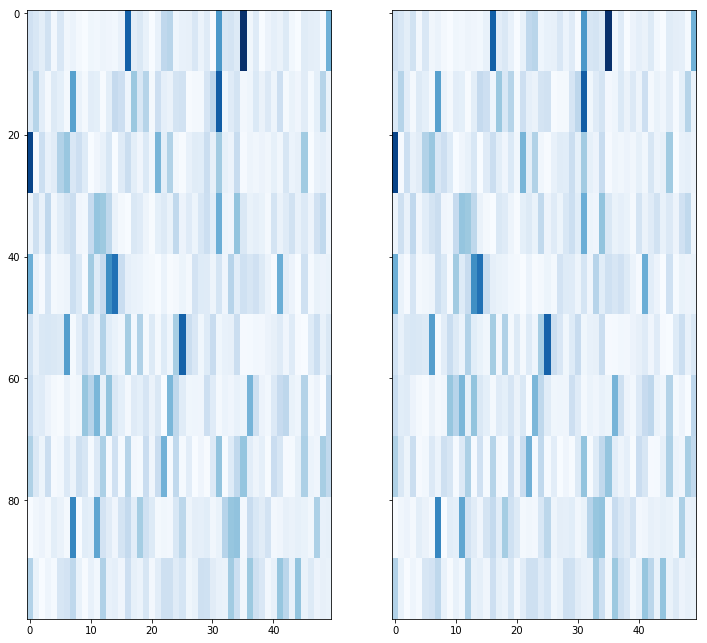

In [8]:
p1 = np.repeat(beta_post, 10, axis=0)
p2 = np.repeat(beta_post1, 10, axis=0)
p = [p1,p2] 
fig, axes = plt.subplots(1, 2, figsize=(12,12), sharey=True)
for i, ax in enumerate(axes.ravel(), 1):
    ax.imshow(p[i-1],cmap='Blues')
pass

The above two plots about the posterior Beta is identical. Therefore, we can conclude that with the same output, our optimization is very successful by improving the running speed by nearly 500%. 

## Simulation Data

For this part, we randomly generate docs according to the generative model for given $\alpha$ and $\beta$. However, measuring the MSE of estimated $\beta$ and true $\beta$ is not approperiate, the topics are not the in the same order and determining the coresponding topic is also hard. Therefore, we create $\beta$ in following way. The intuition is that we want topics to be significantly different from each other. In real world, topics also have little overlap with each other.In addition, we make document to contain mostly three or two topics.

![title](1.png)

In the plot above, the left is the true $\beta$ we generated and the right is the estimated $\beta$ from the model. Although there is some differences, the LDA did find most of the feature from the data and we consider the algorithm to be successful.

## Real World Dataset 

For this part, we use the real world document from the website: http://www.cs.columbia.edu/~blei/lda-c/ to do the testing. The txt file is saved in the github called ap.txt and the ipynb is real world data.ipynb. After processing of the txt file, we run our model to estimate alpha,beta, gamma and phi for the corpus. 

We only choose the first 500 documents to do the analysis because too many documents may cause a very long time to run. However, we still get a good result by discovering the beta parameter, which is the corresponding words in each topic. Mentioned, we select k=10 which means 10 topics to do the clusterings. 

If you are interested in which documents belongs to which topic or which words belongs to which topic, you can look at the gamma and phi we output. For here, we just list some of the beta value because of the limiting spaces, just list some of the high probability vocabularys in each of the topic:

1. Government topic: government, federal, hospital, nations, american, party, service, agents, arrested, report, president, police, agreeement, california, countries, union, operations

2. Financial Topic: Billion, chief, financial, soviet, authorities, economy, congress, percent, cents, meeting, trade, union, state

3. International Economic Topic: months, people, spokesman, national, economic, party, market, york, prices, germany, official, news, bank, war, military

4. International Political Topic: company, country, chief, leader, official, city, soviet, united, committee, president, bush, oil, political, east

5. Others Topic: department, visit, plan, air, police, states, war, force, john, west, group

6. Military Topic: country, government, soviet, largest, fire, congress, israel, military, state, time, trade, oil, support, officials

7. People Topic: country, foreign, people, american, economic, party, public, house, minister, southern, police, administration, bill, trade

8. Daily news Topic: saturday, friday, wednesday, thursday, year, people, business, condition, tuesday, day, working, washionton, week

9. Entertainment Topic: people, rose, center, national, car, bush, than, state, billion, news, chairman 

10. Crime Topic: defense, national, american, soviet, party, house ,united, president, fell, washionton, church, shot, women, children, court 


Note that there are some problems when we are dealing with the stopwords, so there are some stopwords still appear in the documents. But in overall it does not affect the final result a lot. 

## Compare to other algorithm

In this part, we compare the variational EM algorithm with variantional Bayes algorithm applied in the sklearn.We use the same $\beta$ as we mentioned in the simulation part.

| Algorithm|variational EM|variational Bayes|
|-|-|-|
|time|32s|8.92s|

![title](2.png)

In the plot above, the left is the true $\beta$ we generated, the middle is the esitmated $\beta$ from variational EM algorithm and the right is the estimated $\beta$ from the variational Bayes. The variational Bayes has a better performance in time and accuracy since the variantional Bayes is proposed in 2010 which is 7 years late than variantional EM.